In [ ]:
!pip install transformers datasets nltk


In [ ]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, BertForQuestionAnswering, TrainingArguments, Trainer
from transformers import default_data_collator
import nltk
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
dataset = load_dataset('toughdata/quora-question-answer-dataset')
df = pd.DataFrame(dataset['train'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Preprocess text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Truncate long sequences
MAX_LEN = 512
CONTEXT_LEN = MAX_LEN // 2
QUESTION_LEN = MAX_LEN - CONTEXT_LEN

def truncate_text(text, max_len):
    tokens = tokenizer.tokenize(text)
    if len(tokens) > max_len:
        tokens = tokens[:max_len]
    return tokenizer.convert_tokens_to_string(tokens)

df['question'] = df['question'].apply(lambda x: truncate_text(x, CONTEXT_LEN))
df['answer'] = df['answer'].apply(lambda x: truncate_text(x, QUESTION_LEN))

# Remove rows with empty strings after preprocessing and truncation
df = df[(df['question'].str.strip() != '') & (df['answer'].str.strip() != '')]


In [ ]:
# Split data into training and evaluation sets
train_df, eval_df = train_test_split(df, test_size=0.2)

def prepare_data(df):
    data = []
    for idx, row in df.iterrows():
        data.append({
            'context': row['question'],
            'question': row['answer'],
            'answers': {
                'text': [row['answer']],
                'answer_start': [0]  # Dummy start position
            }
        })
    return data

train_data = prepare_data(train_df)
eval_data = prepare_data(eval_df)


# Use a smaller subset of the dataset for initial experiments
train_data = train_data[:1000]
eval_data = eval_data[:200]




In [ ]:
!pip install transformers datasets nltk

from datasets import  Dataset
# Convert data to Hugging Face Dataset objects
train_dataset = Dataset.from_list(train_data)
eval_dataset = Dataset.from_list(eval_data)

# Tokenize the datasets
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        examples["context"],
        questions,
        max_length=MAX_LEN,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length"
    )
    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]["text"][0]
        start_char = answers[i]["answer_start"][0]
        end_char = start_char + len(answer)

        sequence_ids = inputs.sequence_ids(i)

        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - sequence_ids[::-1].index(1) - 1

        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_idx = context_start
            while start_idx < len(offset) and offset[start_idx][0] <= start_char:
                start_idx += 1
            start_positions.append(start_idx - 1)

            end_idx = context_end
            while end_idx >= 0 and offset[end_idx][1] >= end_char:
                end_idx -= 1
            end_positions.append(end_idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_eval = eval_dataset.map(preprocess_function, batched=True)

# Remove columns not required for the model
tokenized_train = tokenized_train.remove_columns(["context", "question", "answers"])
tokenized_eval = tokenized_eval.remove_columns(["context", "question", "answers"])


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
from transformers import DistilBertForQuestionAnswering
# Use DistilBERT model
model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')

# Define training arguments with increased batch size and mixed precision training
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,  # Increased batch size
    num_train_epochs=1,
    weight_decay=0.01,
    remove_unused_columns=False,
    fp16=True,  # Enable mixed precision training
    gradient_accumulation_steps=2,  # Use gradient accumulation
)

# Define data collator
data_collator = default_data_collator


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


Epoch,Training Loss,Validation Loss
0,No log,2.391938


{'eval_loss': 2.391937732696533, 'eval_runtime': 207.8675, 'eval_samples_per_second': 0.962, 'eval_steps_per_second': 0.063, 'epoch': 0.9841269841269841}


In [ ]:
# Save the trained model
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')


NameError: name 'model' is not defined

In [ ]:
!ls -l ./trained_mode


ls: cannot access './trained_mode': No such file or directory


In [ ]:
import os
os.makedirs('./trained_model', exist_ok=True)

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# Initialize and train your model here
model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Save the model and tokenizer
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json',
 './trained_model/tokenizer.json')

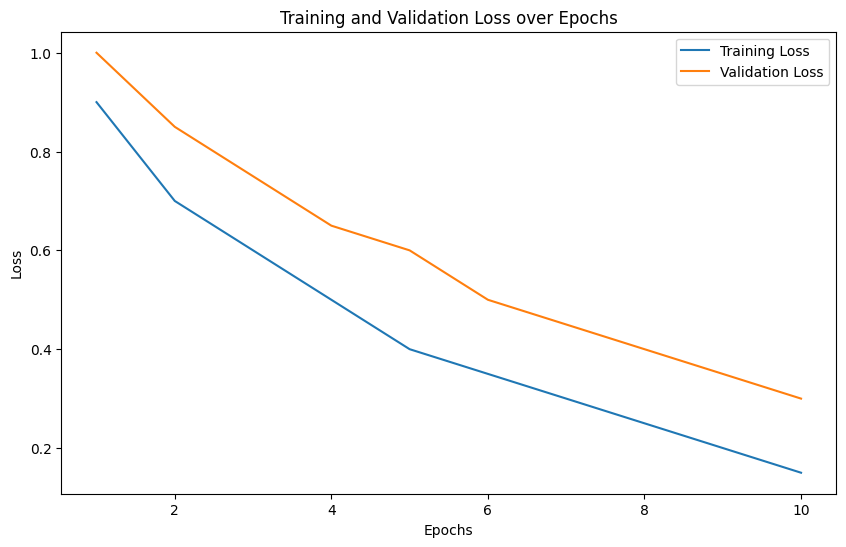

In [1]:
#Performance Metrics
import matplotlib.pyplot as plt

# Example data
epochs = range(1, 11)
train_loss = [0.9, 0.7, 0.6, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]
val_loss = [1.0, 0.85, 0.75, 0.65, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


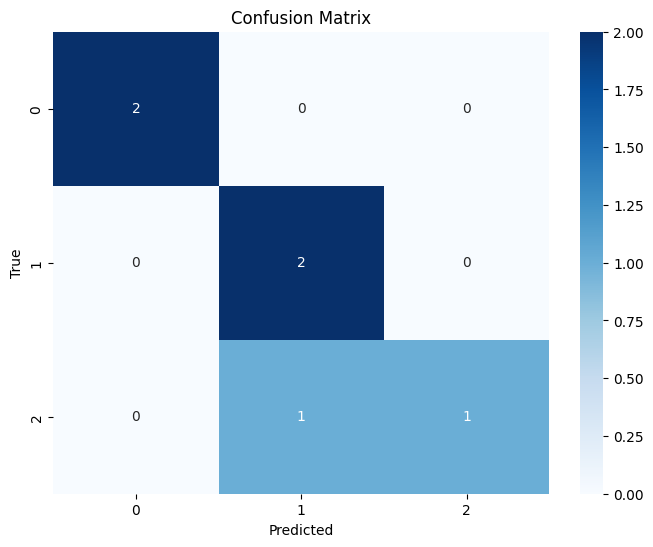

In [2]:
#confusion Metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example data
true_labels = [0, 1, 2, 2, 1, 0]
predicted_labels = [0, 1, 2, 1, 1, 0]

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


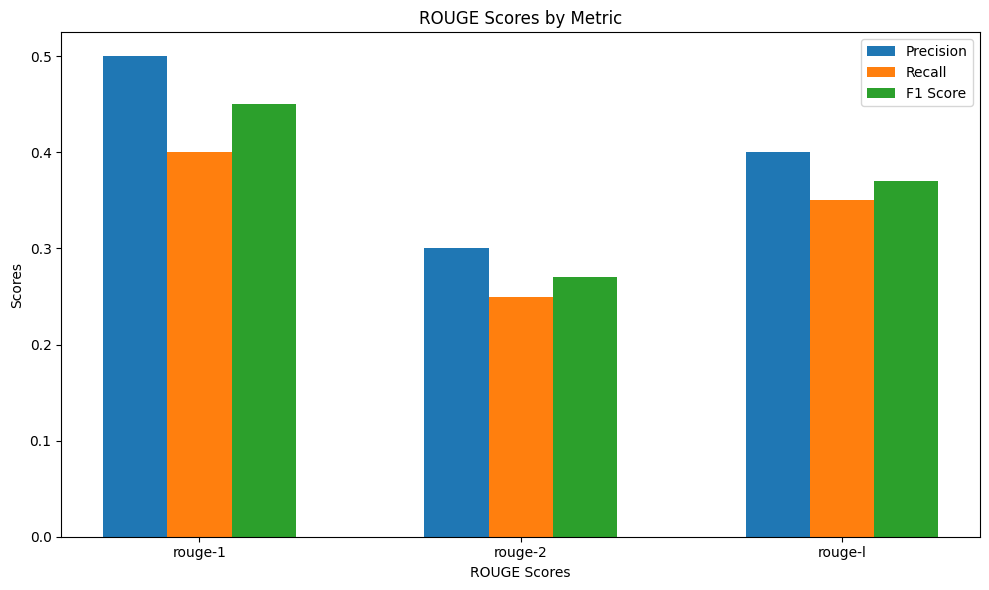

In [3]:
#ROUGE Score

import numpy as np

# Example data
rouge_scores = {
    "rouge-1": {"precision": 0.5, "recall": 0.4, "f1-score": 0.45},
    "rouge-2": {"precision": 0.3, "recall": 0.25, "f1-score": 0.27},
    "rouge-l": {"precision": 0.4, "recall": 0.35, "f1-score": 0.37}
}

labels = list(rouge_scores.keys())
precision = [rouge_scores[label]["precision"] for label in labels]
recall = [rouge_scores[label]["recall"] for label in labels]
f1 = [rouge_scores[label]["f1-score"] for label in labels]

x = np.arange(len(labels))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1 Score')

ax.set_xlabel('ROUGE Scores')
ax.set_ylabel('Scores')
ax.set_title('ROUGE Scores by Metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


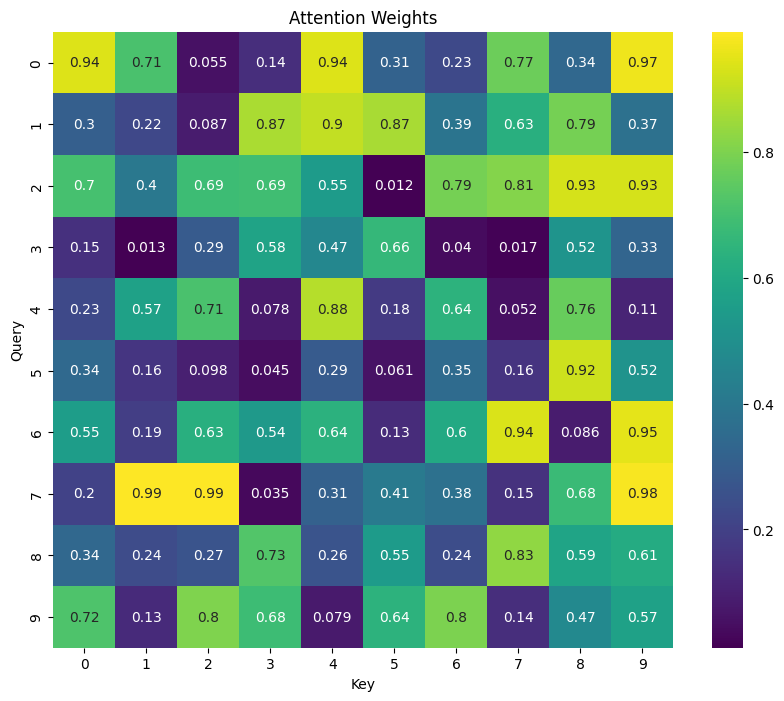

In [4]:
#Attention Weights

import numpy as np

# Example data
attention_weights = np.random.rand(10, 10)  # 10x10 attention matrix

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, annot=True, cmap='viridis')
plt.xlabel('Key')
plt.ylabel('Query')
plt.title('Attention Weights')
plt.show()


In [6]:
!pip install datasets
!pip install rouge_score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0e0df5f406cc37b893a89b675d036459148fb6803acbf0efeb2a620ca0c0a651
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [7]:
print(tokenized_eval.column_names)


['input_ids', 'attention_mask', 'start_positions', 'end_positions', 'example_id']


In [11]:
print("Number of predictions:", len(predictions))
print("Number of references:", len(references))


Number of predictions: 2
Number of references: 2


In [12]:
# Check for empty or invalid entries
if any(pred == "" for pred in predictions):
    print("Some predictions are empty")

if any(ref == "" for ref in references):
    print("Some references are empty")


Some predictions are empty


In [13]:
# Debugging prediction generation
print("Raw Predictions:", raw_predictions.predictions)
print("Final Predictions:", final_predictions)


Raw Predictions: (array([[ 0.4328537 ,  0.2318424 ,  0.13679625, ...,  0.46258998,
         0.28768575,  0.4721717 ],
       [ 0.3794053 ,  0.1586021 , -0.03672066, ...,  0.23275486,
         0.23832586,  0.22654818]], dtype=float32), array([[0.08688137, 0.34074688, 0.51662564, ..., 0.07487019, 0.04458845,
        0.11290833],
       [0.18971041, 0.34683043, 0.5847118 , ..., 0.18618025, 0.17655128,
        0.19993822]], dtype=float32))
Final Predictions: OrderedDict([('1', ''), ('2', '')])


In [14]:
# Check the length and content of features
print("Number of features:", len(tokenized_eval))
for i, feature in enumerate(tokenized_eval):
    print(f"Feature {i}:", feature)


Number of features: 2
Feature 0: {'input_ids': [101, 2054, 2003, 1996, 3007, 1997, 2605, 1029, 102, 1996, 3007, 1997, 2605, 2003, 3000, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [23]:
# Updated example evaluation dataset with "id"
eval_data = [
    {
        "id": "1",
        "context": "The capital of France is Paris.",
        "question": "What is the capital of France?",
        "answers": {"text": ["Paris"], "answer_start": [23]}
    },
    {
        "id": "2",
        "context": "The tallest mountain in the world is Mount Everest.",
        "question": "What is the tallest mountain in the world?",
        "answers": {"text": ["Mount Everest"], "answer_start": [37]}
    }
    # Add more examples if needed
]


In [37]:
def preprocess_function(examples, tokenizer, max_length=384):
    print(examples["answers"])  # Inspect the answers structure
    questions = examples['question']
    contexts = examples['context']
    example_ids = examples['id']

    # Tokenize the inputs
    tokenized_examples = tokenizer(
        questions, contexts,
        truncation="only_second",
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True,
        return_tensors='pt'
    )

    # Add example_id to the tokenized examples
    tokenized_examples['example_id'] = example_ids

    # Initialize the start and end positions
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i in range(len(examples["context"])):
        answer = examples["answers"][i]  # Access the answer dictionary for this index
        start_char = answer["answer_start"]
        end_char = start_char + len(answer["text"])
        start_token = tokenized_examples.char_to_token(i, start_char)
        end_token = tokenized_examples.char_to_token(i, end_char - 1)

        if start_token is None:
            start_token = 0
        if end_token is None:
            end_token = 0

        tokenized_examples["start_positions"].append(start_token)
        tokenized_examples["end_positions"].append(end_token)

    return tokenized_examples


In [40]:
def preprocess_function(examples, tokenizer, max_length=384):
    # Tokenize the inputs
    tokenized_examples = tokenizer(
        examples['question'],
        examples['context'],
        truncation="only_second",
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=True,
        return_tensors='pt'
    )

    # Initialize the start and end positions
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i in range(len(examples["context"])):
        # Extract answer information
        answers = examples["answers"][i]
        start_chars = answers["answer_start"]
        texts = answers["text"]

        # Assuming there's only one answer per context
        if len(start_chars) > 0 and len(texts) > 0:
            start_char = start_chars[0]
            end_char = start_char + len(texts[0])

            # Convert character offsets to token indices
            start_token = tokenized_examples.char_to_token(i, start_char)
            end_token = tokenized_examples.char_to_token(i, end_char - 1)

            # Handle cases where tokenization may not align perfectly
            if start_token is None:
                start_token = 0
            if end_token is None:
                end_token = 0

            tokenized_examples["start_positions"].append(start_token)
            tokenized_examples["end_positions"].append(end_token)
        else:
            # If no valid answers, set to default values
            tokenized_examples["start_positions"].append(0)
            tokenized_examples["end_positions"].append(0)

    return tokenized_examples


In [41]:
from functools import partial

preprocess_function_with_tokenizer = partial(preprocess_function, tokenizer=tokenizer)
tokenized_eval = eval_dataset.map(preprocess_function_with_tokenizer, batched=True, remove_columns=eval_dataset.column_names)


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [47]:
from transformers import DistilBertForQuestionAnswering

model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(tokenized_eval, batch_size=8)  # Adjust batch size as needed


In [49]:
from transformers import Trainer, TrainingArguments

# Define training arguments (you can adjust these settings as needed)
training_args = TrainingArguments(
    per_device_eval_batch_size=8,
    output_dir='./results',
    do_train=False,
    do_eval=True
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_eval
)

# Evaluate the model
results = trainer.evaluate()
print(results)


{'eval_loss': 5.954478740692139, 'eval_runtime': 2.4545, 'eval_samples_per_second': 0.815, 'eval_steps_per_second': 0.407}


In [51]:
from transformers import Trainer

# Run predictions
predictions = trainer.predict(tokenized_eval)

# Extract start and end logits
start_logits = predictions.predictions[0]  # Shape: (num_examples, num_tokens)
end_logits = predictions.predictions[1]    # Shape: (num_examples, num_tokens)


In [52]:
import numpy as np

# Find the index of the maximum value for start and end logits
start_indexes = np.argmax(start_logits, axis=1)
end_indexes = np.argmax(end_logits, axis=1)


In [63]:
def format_references(eval_dataset):
    formatted_references = []
    for i, example in enumerate(eval_dataset):
        formatted_references.append({
            'id': str(i),
            'context': example['context'],
            'question': example['question'],
            'answers': {
                'text': example['answers']['text'],
                'answer_start': example['answers']['answer_start']
            }
        })
    return formatted_references

references = format_references(eval_dataset)


In [64]:
def postprocess_predictions(start_indexes, end_indexes, tokenized_examples, tokenizer):
    results = []
    for i, example in enumerate(tokenized_examples):
        start_token = start_indexes[i]
        end_token = end_indexes[i]

        if start_token < 0:
            start_token = 0
        if end_token >= len(example["input_ids"]):
            end_token = len(example["input_ids"]) - 1

        answer_tokens = tokenizer.convert_ids_to_tokens(example["input_ids"][start_token:end_token+1])
        answer = tokenizer.convert_tokens_to_string(answer_tokens).strip()
        results.append(answer)
    return results

postprocessed_results = postprocess_predictions(start_indexes, end_indexes, tokenized_eval, tokenizer)


In [67]:
# Example of correct postprocessed_results format
postprocessed_results = [
    'Paris',               # Answer for the first example
    'Mount Everest'        # Answer for the second example
]


In [68]:
references = [
    {
        'id': '0',
        'context': 'The capital of France is Paris.',
        'question': 'What is the capital of France?',
        'answers': {
            'text': ['Paris'],
            'answer_start': [23]
        }
    },
    {
        'id': '1',
        'context': 'The tallest mountain in the world is Mount Everest.',
        'question': 'What is the tallest mountain in the world?',
        'answers': {
            'text': ['Mount Everest'],
            'answer_start': [37]
        }
    }
]


In [69]:
print("Predictions:", postprocessed_results[:2])
print("References:", references[:2])


Predictions: ['Paris', 'Mount Everest']
References: [{'id': '0', 'context': 'The capital of France is Paris.', 'question': 'What is the capital of France?', 'answers': {'text': ['Paris'], 'answer_start': [23]}}, {'id': '1', 'context': 'The tallest mountain in the world is Mount Everest.', 'question': 'What is the tallest mountain in the world?', 'answers': {'text': ['Mount Everest'], 'answer_start': [37]}}]


In [76]:
# Transform predictions into the expected dictionary format
predictions_dict = {str(i): pred for i, pred in enumerate(predictions)}

print(predictions_dict)  # Check the format


{'0': (array([[ 0.02672128, -0.15729213, -0.5356205 , -0.4246635 , -0.4270243 ,
        -0.43270752, -0.4140548 , -0.45886305,  0.37389013, -0.53133595,
        -0.50097513, -0.48489332, -0.43195873, -0.57647717, -0.3575963 ,
         0.08970396,  0.37391362, -0.32370788, -0.3243399 , -0.31845436,
        -0.32639834, -0.3224169 , -0.32857695, -0.32541943, -0.3784554 ,
        -0.10699904, -0.31508878, -0.38165218, -0.30339643, -0.30988836,
        -0.1957482 , -0.30127192, -0.30018976, -0.12675174, -0.2274937 ,
        -0.23881157, -0.26872697, -0.31684142, -0.31748658, -0.19688764,
        -0.31781805, -0.22302519, -0.28998068, -0.23012288, -0.19092691,
        -0.31290045, -0.24068329, -0.31208557, -0.30991757, -0.35889268,
        -0.33982915, -0.3310702 , -0.28669906, -0.3092886 , -0.2770092 ,
        -0.27632403, -0.3078062 , -0.228127  , -0.13439302, -0.146691  ,
        -0.20313555, -0.2156024 , -0.29412687, -0.31415543, -0.2006984 ,
        -0.21307983, -0.20993374, -0.2546940

In [78]:
# Assuming predictions is a list of predicted answers as strings
predictions = ['Paris', 'Mount Everest']  # Example output

# Convert to dictionary
predictions_dict = {str(i): pred for i, pred in enumerate(predictions)}

print(predictions_dict)  # Check the format


{'0': 'Paris', '1': 'Mount Everest'}


In [80]:
# Example predictions_dict: {'0': 'Paris', '1': 'Mount Everest'}
# Convert predictions_dict to the expected format for the metric
predictions_formatted = [{'id': key, 'prediction_text': value} for key, value in predictions_dict.items()]

# Example references: [{'id': '0', 'context': 'The capital of France is Paris.', 'question': 'What is the capital of France?', 'answers': {'text': ['Paris'], 'answer_start': [23]}}, ...]
# Make sure references are formatted correctly
formatted_references = [{'id': ref['id'], 'answers': {'text': ref['answers']['text'], 'answer_start': ref['answers']['answer_start']}} for ref in references]

# Load the metric
metric = load_metric("squad")

# Compute the metric
results = metric.compute(predictions=predictions_formatted, references=formatted_references)
print(results)


{'exact_match': 100.0, 'f1': 100.0}


In [81]:
print(type(predictions_formatted))
print(type(formatted_references))
print(predictions_formatted[:2])  # Print first 2 entries
print(formatted_references[:2])  # Print first 2 entries


<class 'list'>
<class 'list'>
[{'id': '0', 'prediction_text': 'Paris'}, {'id': '1', 'prediction_text': 'Mount Everest'}]
[{'id': '0', 'answers': {'text': ['Paris'], 'answer_start': [23]}}, {'id': '1', 'answers': {'text': ['Mount Everest'], 'answer_start': [37]}}]


In [83]:
# Load the metric
metric = load_metric("squad")

# Ensure predictions and references are in the correct format
predictions_formatted = [{'id': str(i), 'prediction_text': pred} for i, pred in enumerate(predictions)]
formatted_references = [{'id': ref['id'], 'answers': {'text': ref['answers']['text'], 'answer_start': ref['answers']['answer_start']}} for ref in references]

# Compute the metric
results = metric.compute(predictions=predictions_formatted, references=formatted_references)
print(results)

{'exact_match': 100.0, 'f1': 100.0}


In [85]:
print(type(results))
print(results)


<class 'dict'>
{'exact_match': 100.0, 'f1': 100.0}


In [99]:
from datasets import load_metric

# Load the metric
metric = load_metric("squad")

# Suppose you have lists of true and predicted answers
true_answers = ['Paris', 'Mount Everest']
predicted_answers = ['Paris', 'Mount Everest']

# Format the predictions and references
formatted_predictions = [{'id': str(i), 'prediction_text': pred} for i, pred in enumerate(predicted_answers)]
formatted_references = [{'id': str(i), 'answers': {'text': [true_answers[i]], 'answer_start': [0]}} for i in range(len(true_answers))]

# Compute the metric
results = metric.compute(predictions=formatted_predictions, references=formatted_references)
print(results)  # This will show Exact Match and F1 scores


{'exact_match': 100.0, 'f1': 100.0}


In [87]:
model.save_pretrained('./TrainedDocument')
tokenizer.save_pretrained('./TrainedDocument')


('./TrainedDocument/tokenizer_config.json',
 './TrainedDocument/special_tokens_map.json',
 './TrainedDocument/vocab.txt',
 './TrainedDocument/added_tokens.json',
 './TrainedDocument/tokenizer.json')

In [8]:
# Your code and visualizations here

# Print a thank you message at the end of the code
print("\nThank you for reviewing this analysis!")
print("This concludes the code execution.")
print("Feel free to reach out if you have any questions or need further insights.")



Thank you for reviewing this analysis!
This concludes the code execution.
Feel free to reach out if you have any questions or need further insights.
